In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set(style='ticks', palette='Set2')
%matplotlib inline

In [2]:
# Feature Space Z:
Z = np.array([[f1, f2, f3] 
             for f1 in xrange(2) 
             for f2 in xrange(2) 
             for f3 in xrange(2)])

# Hypothesis Space H:
H = {
        0: lambda t: t[0],     # h1:  triangle
        1: lambda t: 1 - t[0], # h1': circle
        2: lambda t: t[1],     # h2:  real
        3: lambda t: 1 - t[1], # h2': dotted
        4: lambda t: t[2],     # h3:  pink
        5: lambda t: 1 - t[2]  # h3': bule
    }

# Ground Truth Set G:
X = Z[np.random.choice(len(Z), size=10)]
G = [(x, H[4](x)) for x in X]

# Initialize the Teacher
from pvc import *
teacher = PedagogicalReasoning(Z, H, G, alpha=3, gamma=0.6)

# Initialize the Student
from utils import *
from simulation import *
student = Student(H, stu_type="median")    

# Define reward:
def rw(prev, cur, eps=0.001):
    if prev-eps > cur:
        return 0.0
    elif cur - prev + eps > 0.6 * (1.0 - prev):
        return 1.0
    else: 
        return (cur - prev + eps) / (0.6 * (1.0 - prev + eps))
    
# Visualize the Ground Truth Set
# print "GROUND TRUTH:"
# vis_data(G)

In [3]:
curves = {"round": [], "type": [], "value": []}
rewards = {"round": [], "type": [], "value": []}
num_eg = {"round": [], "type": [], "value": []}
def insert_log(r, t, v):
    if t == "reward":
        rewards["round"].append(r)
        rewards["type"].append(t)
        rewards["value"].append(v)
    elif t == "#eg":
        num_eg["round"].append(r)
        num_eg["type"].append(t)
        num_eg["value"].append(v)
    else:
        curves["round"].append(r)
        curves["type"].append(t)
        curves["value"].append(v)

In [4]:
k = 10
N = 5
init_belief = l1normalize(np.random.rand(len(H)))
# init_belief = np.array([0.2,0.0,0.2,0.0,0.6,0.0])
for repeat in xrange(10):
    ot = []
    student.reset(belief=init_belief, stu_type="weak")
    last_est_eta = 0.0
    for rnd in xrange(N):
        # Sample k questions
        queries = Z[np.random.choice(len(Z), size=k)]
        # Practice Phase
        answers = student.practice(queries)
        est_rhos, est_eta = teacher.belief_estimate(answers)
        insert_log(rnd, "real", student.real_eta(G))
        insert_log(rnd, "estimated", est_eta)
        if rnd > 0: insert_log(rnd, "reward", rw(last_est_eta, est_eta))
        else: insert_log(rnd, "reward", 0.0)
        if rnd < N-1: insert_log(rnd+1, "target", 0.6*(1-est_eta)+est_eta)
        # Teaching Phase
        examples, tilde_eta = teacher.teach(ot, est_rhos, est_eta, G)
        insert_log(rnd, "#eg", len(examples))        
        ot = ot + examples
        student.learn(ot)
        last_est_eta = est_eta

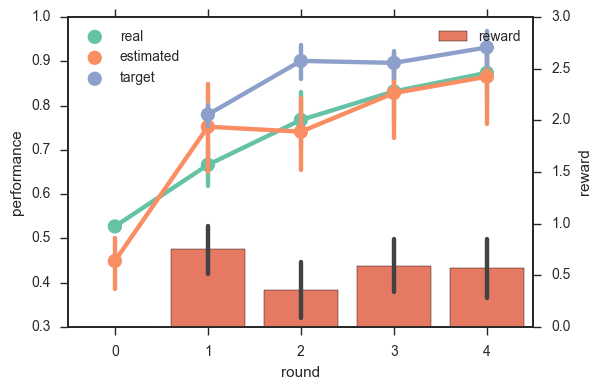

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = sns.pointplot(x="round", y="value", hue="type", data=curves)
ax2 = ax1.twinx()
ax2 = sns.barplot(x="round", y="value", hue="type", palette="Reds_r", data=rewards)
ax2.set(ylim=(0.0, 3));
ax1.set_xlabel("round");
ax1.set_ylabel("performance");
ax2.set_ylabel("reward");

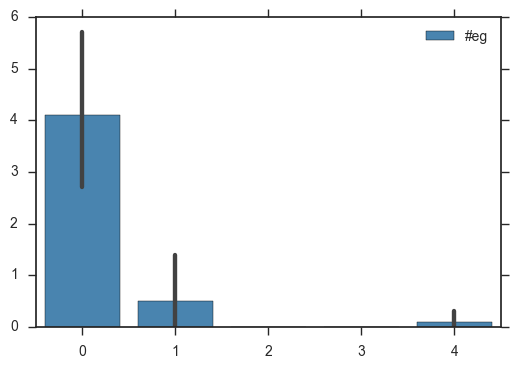

In [6]:
ax = sns.barplot(x="round", y="value", hue="type", palette="Blues_d", data=num_eg)

In [19]:
model_curves = {"round": [], "type": [], "value": []}
for rnd in xrange(N):
    if rnd == 0:
        student.reset(belief=init_belief)
        eta = student.real_eta(G)
    model_curves["round"].append(rnd)
    model_curves["type"].append("model_student")
    model_curves["value"].append(eta)
    eta = eta + 0.6*(1 - eta)
    
model_curves["round"] = curves["round"] + model_curves["round"]
model_curves["type"] = curves["type"] + model_curves["type"]
model_curves["value"] = curves["value"] + model_curves["value"]

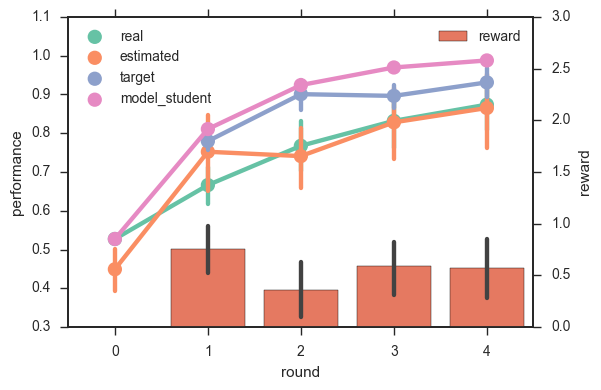

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1 = sns.pointplot(x="round", y="value", hue="type", data=model_curves)
ax2 = ax1.twinx()
ax2 = sns.barplot(x="round", y="value", hue="type", palette="Reds_r", data=rewards)
ax2.set(ylim=(0.0, 3));
ax1.set_xlabel("round");
ax1.set_ylabel("performance");
ax2.set_ylabel("reward");
# fig.savefig("output.png")

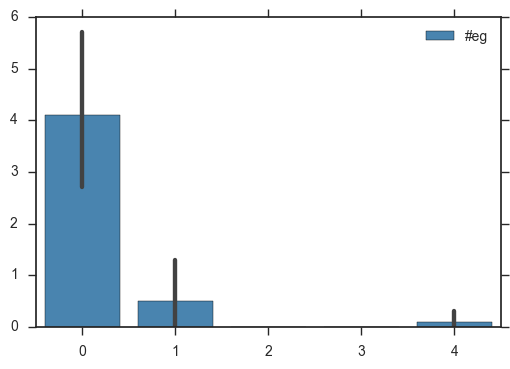

In [28]:
fig_eg = plt.figure()
ax = sns.barplot(x="round", y="value", hue="type", palette="Blues_d", data=num_eg)
# fig_eg.savefig("output.png")